In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import zfit

from scipy import stats
from scipy.optimize import curve_fit

MP = 0.93827208816
E0 = 4.81726
ME = 0.00051099895

/usr/local/lib/python3.7/site-packages/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [9]:
@np.vectorize
def center_phi(phi, sec):
    sector = {
        1: 90,
        2: 30,
        3: -30,
        4: -90,
        5: -150,
        6: 150
    }
    
    return phi-sector[sec]

@np.vectorize
def Theta_e_calc(theta_p):
    return 2 * np.arctan(MP/((E0+MP)*np.tan(theta_p)))

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

@np.vectorize
def calc_W(e_p, e_theta, e_phi):
    px = e_p*np.sin(e_theta)*np.cos(e_phi)
    py = e_p*np.sin(e_theta)*np.sin(e_phi)
    pz = e_p*np.cos(e_theta)
    
    e_beam = np.array([0, 0, np.sqrt(E0**2-ME**2), E0])
    e_prime = np.array([px, py, pz, np.linalg.norm([px, py, pz, ME])])
    p_targ = np.array([0, 0, 0.0, MP])
    temp = e_beam - e_prime + p_targ
    temp2 = temp[0]*temp[0]+temp[1]*temp[1]+temp[2]*temp[2]-temp[3]*temp[3]
    return np.sqrt(-temp2)
    
@np.vectorize
def q2_calc(e_p, e_theta, e_phi):
    px = e_p*np.sin(e_theta)*np.cos(e_phi)
    py = e_p*np.sin(e_theta)*np.sin(e_phi)
    pz = e_p*np.cos(e_theta)
    
    e_beam = np.array([0, 0, np.sqrt(E0**2-ME**2), E0])
    e_prime = np.array([px, py, pz, np.linalg.norm([px, py, pz, ME])])
    
    temp = e_beam - e_prime
    temp2 = temp[0]*temp[0]+temp[1]*temp[1]+temp[2]*temp[2]-temp[3]*temp[3]

    return temp2

def FitFunc(phi_e, theta_e, 
            alpha_A, beta_A, gamma_A, 
            alpha_B, beta_B, gamma_B, 
            alpha_C, beta_C, gamma_C,
            alpha_D, beta_D, gamma_D,
            alpha_E, beta_E, gamma_E):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (alpha_A * theta_e**2 + beta_A * theta_e + gamma_A) * phi_e**4
    B = (alpha_B * theta_e**2 + beta_B * theta_e + gamma_B) * phi_e**3
    C = (alpha_C * theta_e**2 + beta_C * theta_e + gamma_C) * phi_e**2
    D = (alpha_D * theta_e**2 + beta_D * theta_e + gamma_D) * phi_e
    E = (alpha_E * theta_e**2 + beta_E * theta_e + gamma_E)
    
    return A + B + C + D + E


def Dtheta(phi_e, theta_e, A, B, C, D, Bt):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (A+B*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (C+D*phi_e)*np.sin(theta_e)
    return first + second

def Dpp(phi_e, theta_e, p, E, F, G, H):
    first = (E+F*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (G+H*phi_e)*np.sin(theta_e)
    
    return (first + second)*(p/Bt)
    


In [10]:
df = pd.read_csv("~/Desktop/show/mom_corr_elastic.dat")
df = df[(df.W_uncorr > 0.85) & (df.W_uncorr < 1.2)]
df['e_theta'] = np.deg2rad(df.e_theta)
df['e_phi_center'] = np.deg2rad(center_phi(df.e_phi, df.sector))
df['e_phi'] = np.deg2rad(df.e_phi)
df['p_theta'] = np.deg2rad(df.p_theta)
df['p_phi'] = np.deg2rad(df.p_phi)
df['e_theta_calc'] = Theta_e_calc(df.p_theta)
df['delta_theta'] = df['e_theta_calc']-df['e_theta']
df['w_corr'] = calc_W(df.e_p, df.e_theta, df.e_phi)
df['q2_corr'] = q2_calc(df.e_p, df.e_theta, df.e_phi)
df['p_p_calc'] = Theta_e_calc(df.e_theta_calc)
df = df[np.abs(df.delta_theta) < 0.005]

print(len(df))

248916


In [11]:
df.head()

,e_p,e_theta,e_phi,p_p,p_theta,p_phi,W_uncorr,Q2_uncorr,sector,e_phi_center,e_theta_calc,delta_theta,w_corr,q2_corr,p_p_calc
0,3.867114,0.302877,-0.630023,1.606884,0.822251,2.523154,0.983592,1.695892,3,-0.106424,0.300571,-0.002306,0.983592,1.695893,0.968364
2,3.823474,0.320880,1.468849,1.707246,0.789636,-1.651257,0.930052,1.880240,1,-0.101948,0.320518,-0.000362,0.930053,1.880239,0.912973
4,3.808950,0.320004,2.788525,1.675734,0.789702,-0.359243,0.953690,1.862967,6,0.170531,0.320476,0.000472,0.953689,1.862969,0.913083
5,4.044248,0.268281,-1.527046,1.388920,0.881333,1.606775,0.968046,1.393833,4,0.043751,0.267199,-0.001082,0.968045,1.393835,1.074239
6,3.907971,0.292540,1.706743,1.572335,0.835882,-1.425245,0.993494,1.599645,1,0.135946,0.292574,0.000033,0.993494,1.599645,0.992134


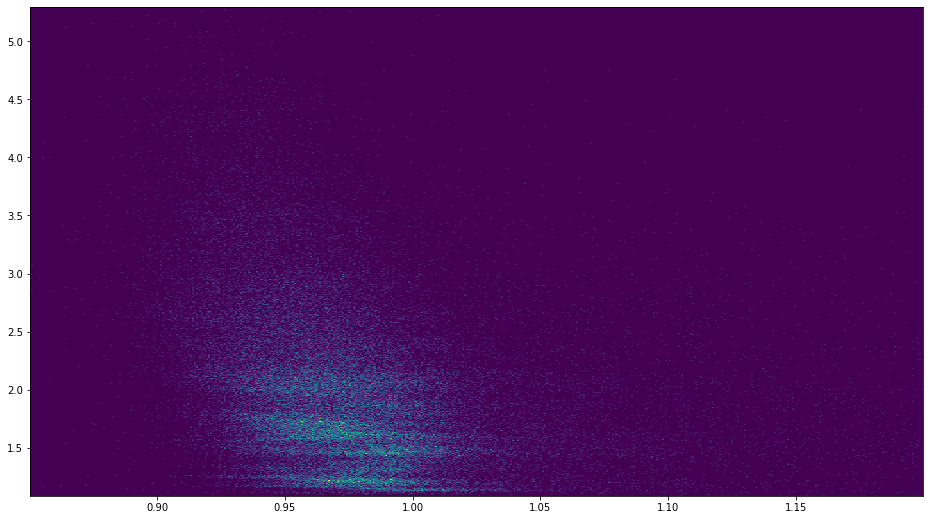

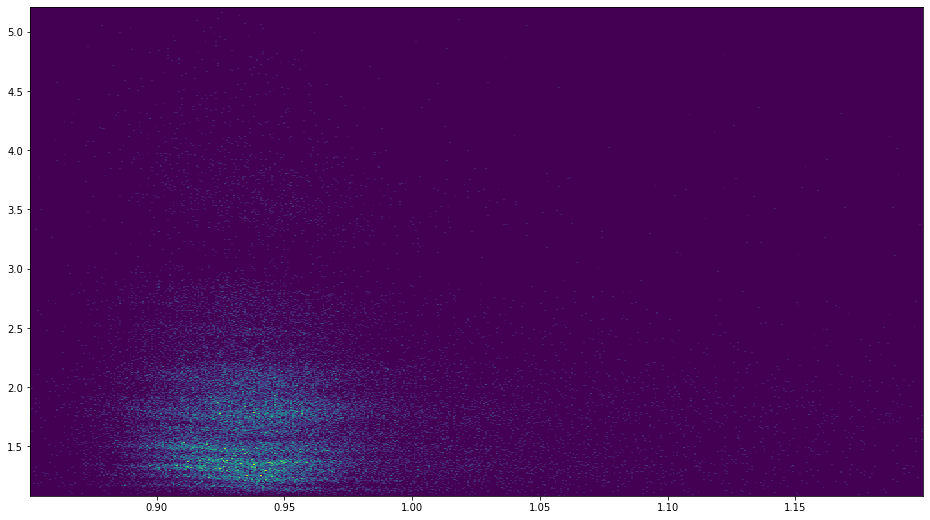

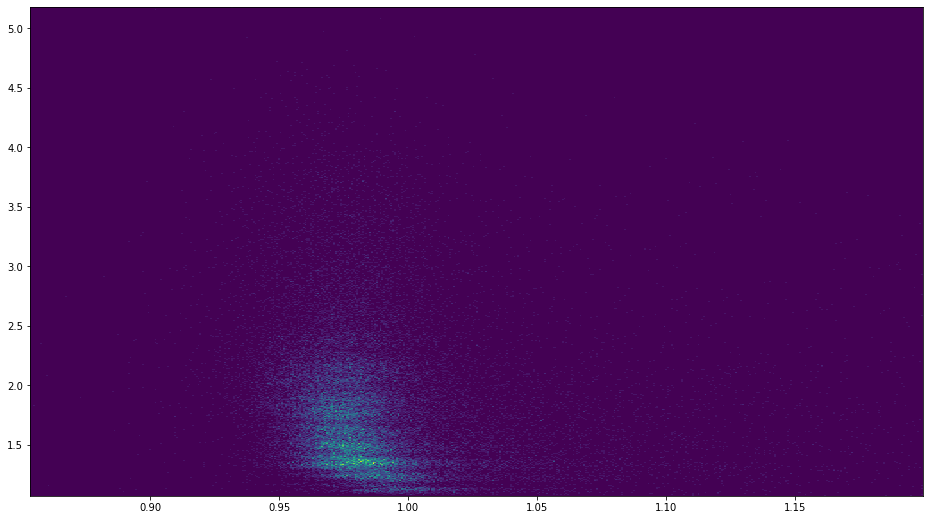

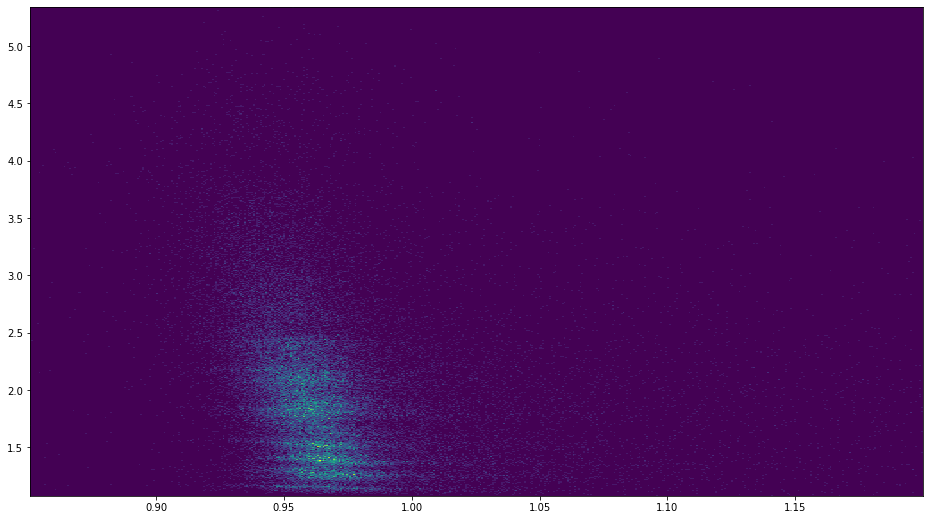

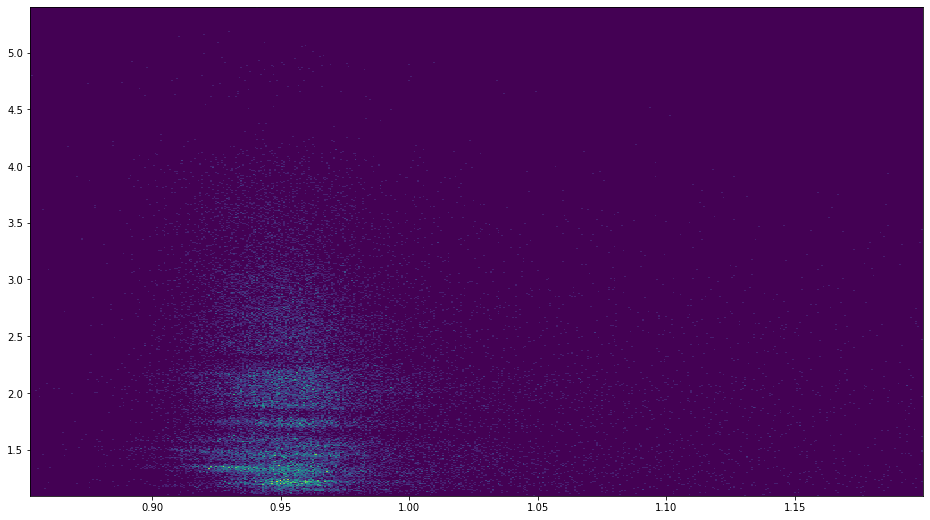

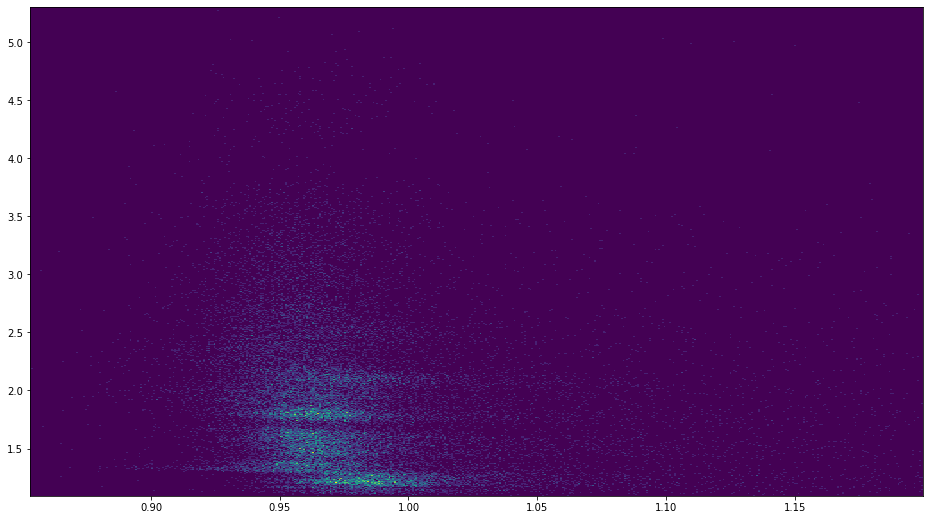

In [12]:
#for sec in np.unique(df.sector):
#    fig = plt.figure(figsize=(16,9))
#    d = df[df.sector == sec]
#    plt.hist2d(-(d.p_p_calc-d.p_p)/d.p_p,d.e_theta, bins=500)    
#    plt.show()
    
    
for sec in np.unique(df.sector):
    fig = plt.figure(figsize=(16,9))
    d = df[df.sector == sec]
    plt.hist2d(d.w_corr, d.q2_corr, bins=500)    
    plt.show()

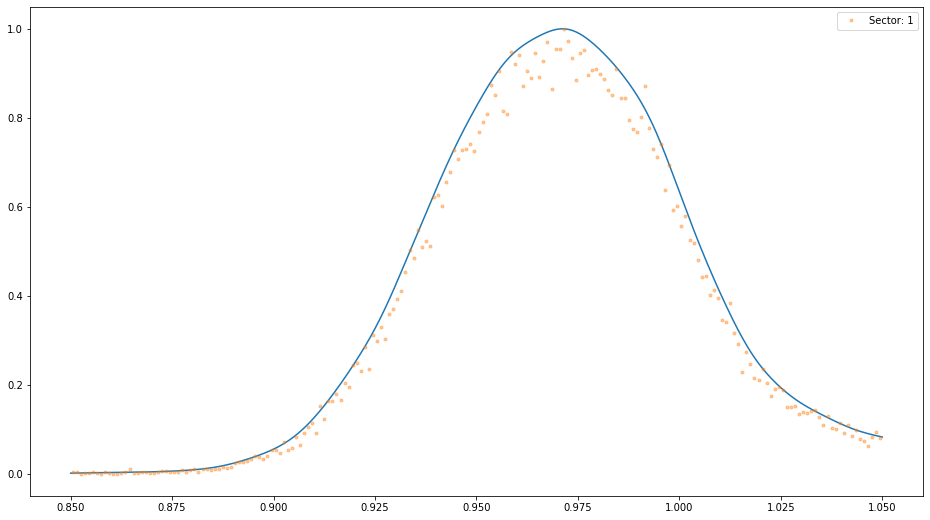

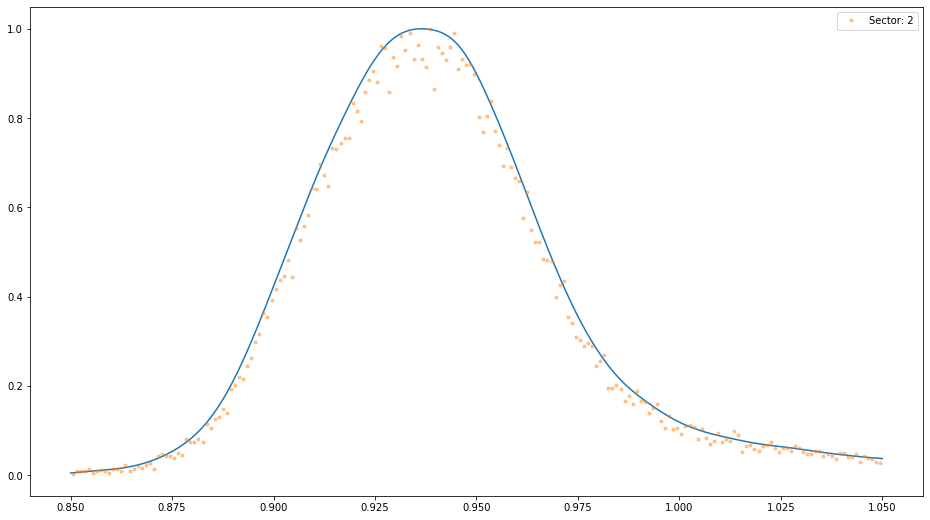

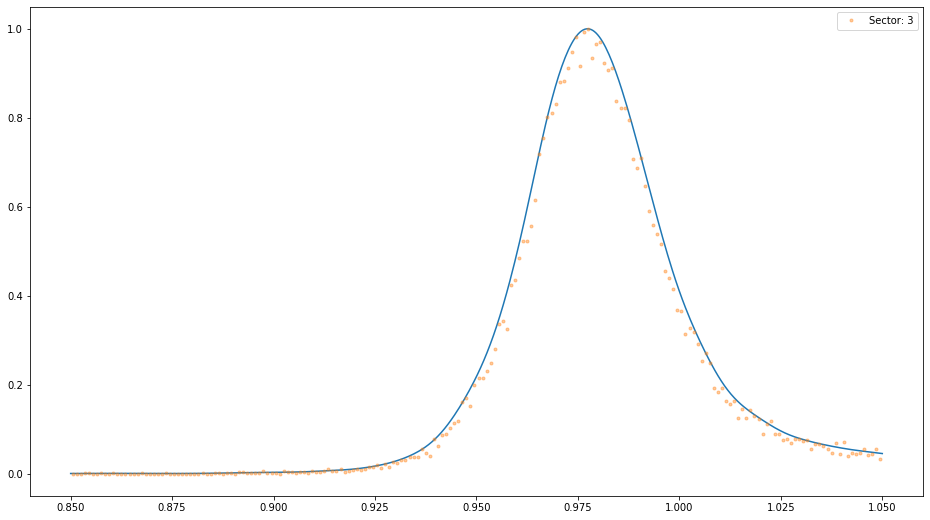

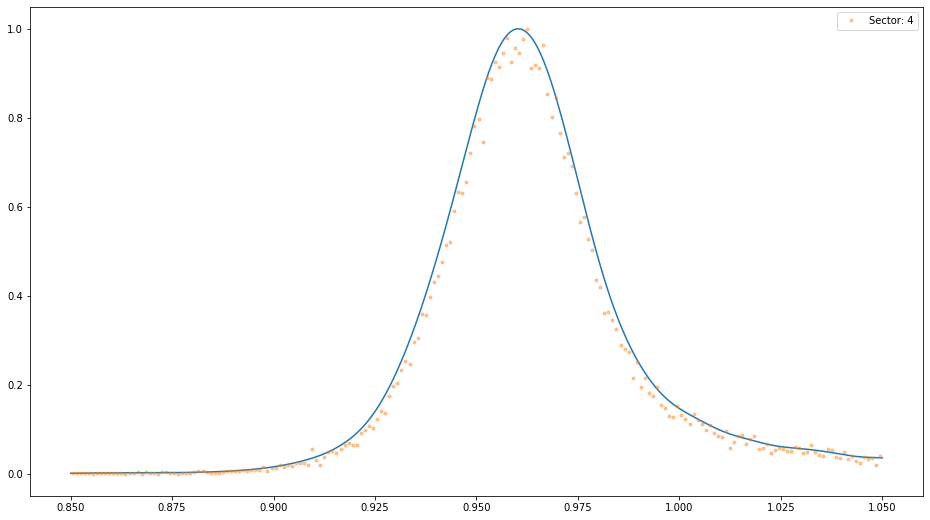

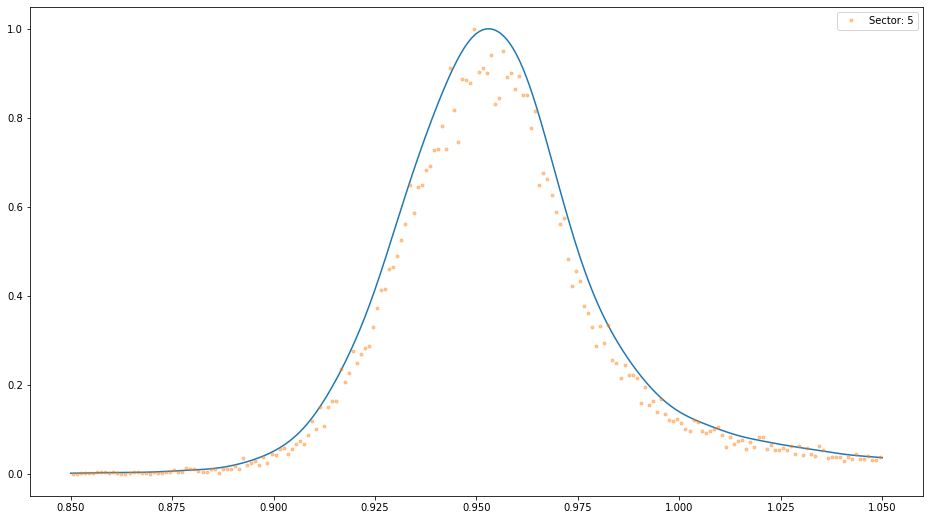

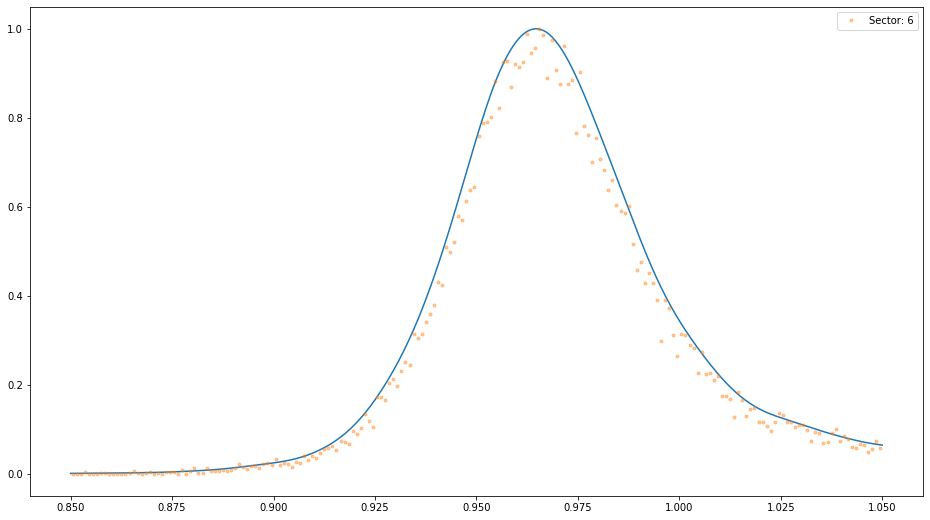

In [25]:
for sec in np.unique(df.sector):
    fig = plt.figure(figsize=(16,9))
    xs=np.linspace(0.85, 1.05, 500)
    data = df[df.sector == sec]
    y, x= np.histogram(data['W_uncorr'], bins=200, range=(0.85,1.05))
    y = y/np.max(y)
    kde = stats.gaussian_kde(data['W_uncorr'])
    plt.plot(xs, kde(xs)/np.max(kde(xs)))
    x = (x[:-1]+x[1:])/2.0
    plt.errorbar(x,y,fmt='.',alpha=0.4, label=f'Sector: {sec}')

    plt.legend()
    plt.show()

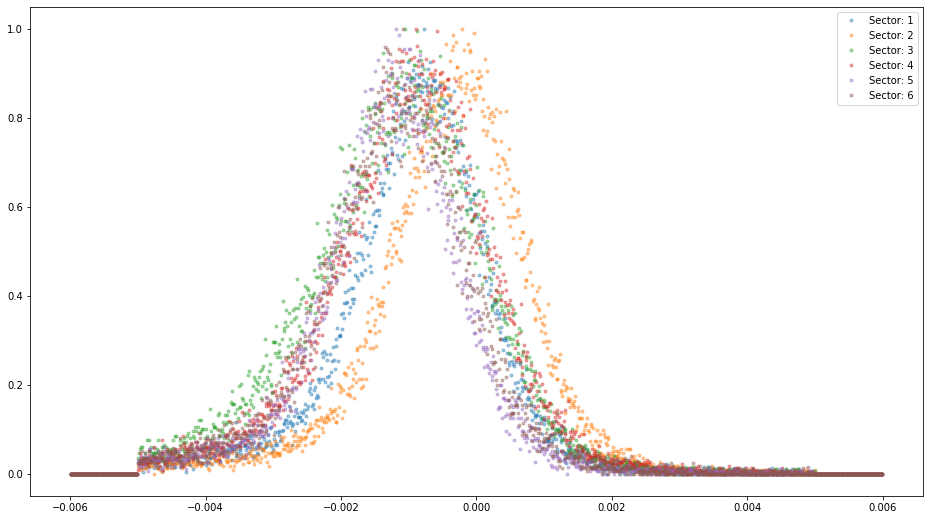

In [23]:
fig = plt.figure(figsize=(16,9))
for sec in np.unique(df.sector):
    data = df[df.sector == sec]
    y,x = np.histogram(data['delta_theta'], bins=1000, range=(-0.006,0.006))
    y = y/np.max(y)
    x = (x[:-1]+x[1:])/2.0
    plt.errorbar(x,y,fmt='.', alpha=0.4, label=f'Sector: {sec}')
plt.legend()
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


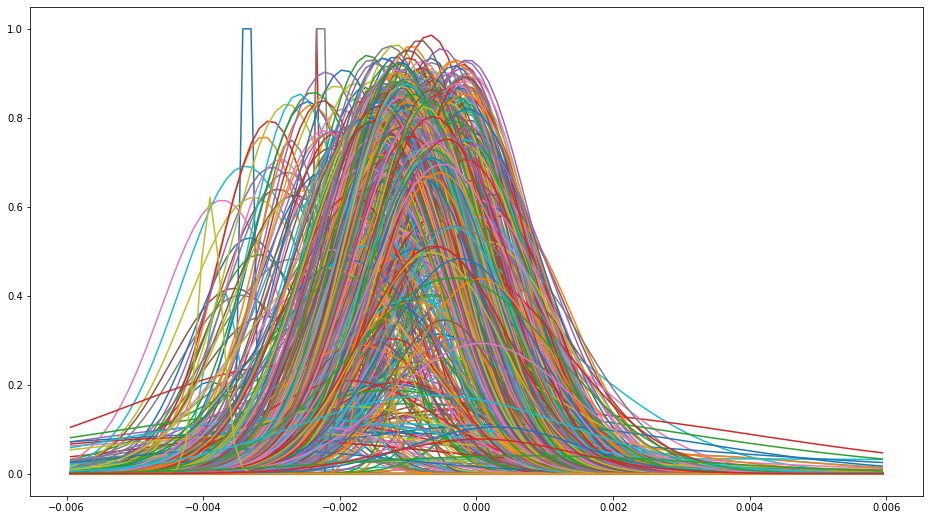

In [15]:
fig = plt.figure(figsize=(16,9))
num_points = 100
grr = []
for sec in range(1,7):
    df2 = df[df.sector == sec]
    phis = np.linspace(np.min(df2.e_phi_center), np.max(df2.e_phi_center), num_points+1)
    for phi in range(0, num_points):
        phi_min = phis[phi]
        phi_max = phis[phi+1]
        data = df2[(df2.e_phi_center > phi_min) & (df2.e_phi_center <= phi_max)]
        y, x = np.histogram(data['delta_theta'], bins=100, range=(-0.006,0.006))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        #plt.errorbar(x,y,fmt='o-',alpha=0.4)
        if not np.any(np.isnan(y)) and len(y) > 5:
            try:
                popt, pcov = curve_fit(gauss, x, y, 
                                       p0 = [1, np.mean(data['delta_theta']), np.std(data['delta_theta'])], 
                                       maxfev=80000)
                if np.abs(popt[1]) < 0.05:
                    grr.append([((phi_min+phi_max) / 2.0), popt[1], popt[2], sec])
                    plt.plot(x,gauss(x,*popt))
            except RuntimeError:
                pass
            
plt.show()
grr = np.array(grr)
dfgrr = pd.DataFrame(data=grr, columns=["phi", "dtheta", "sigma", "sec"])

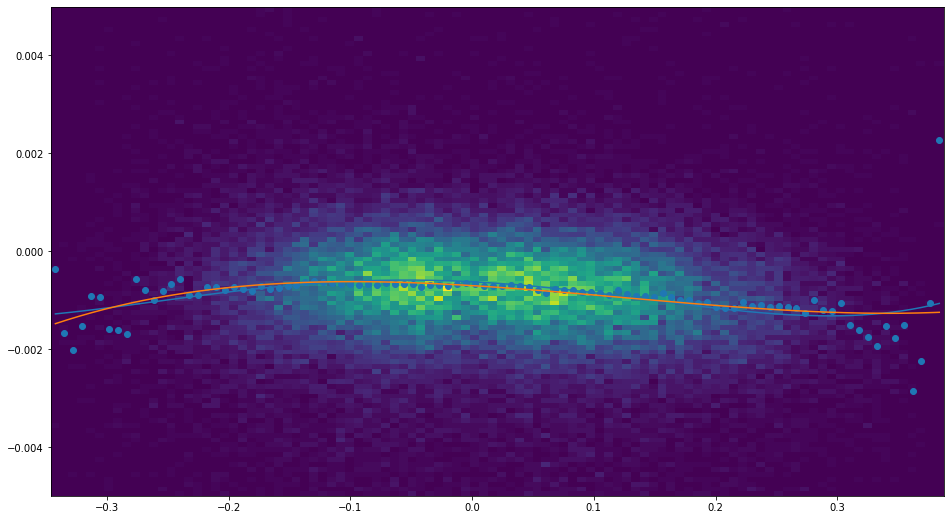

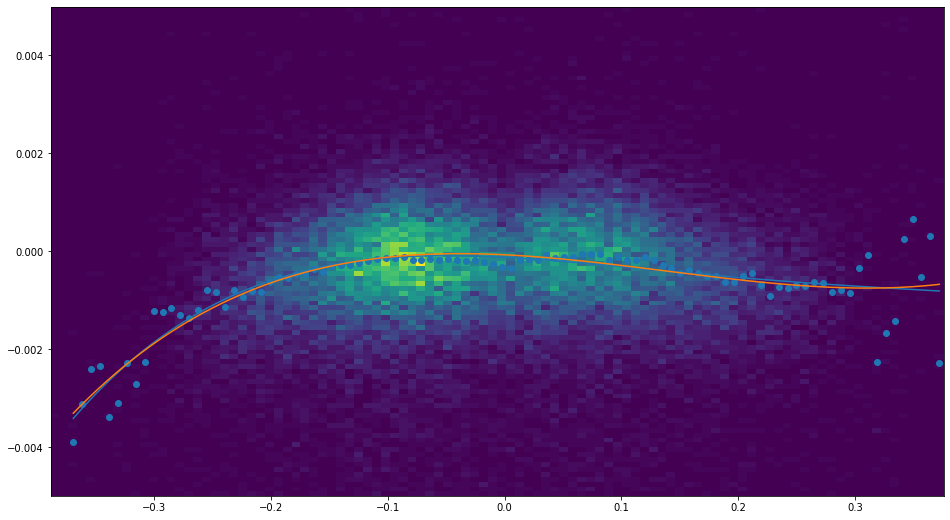

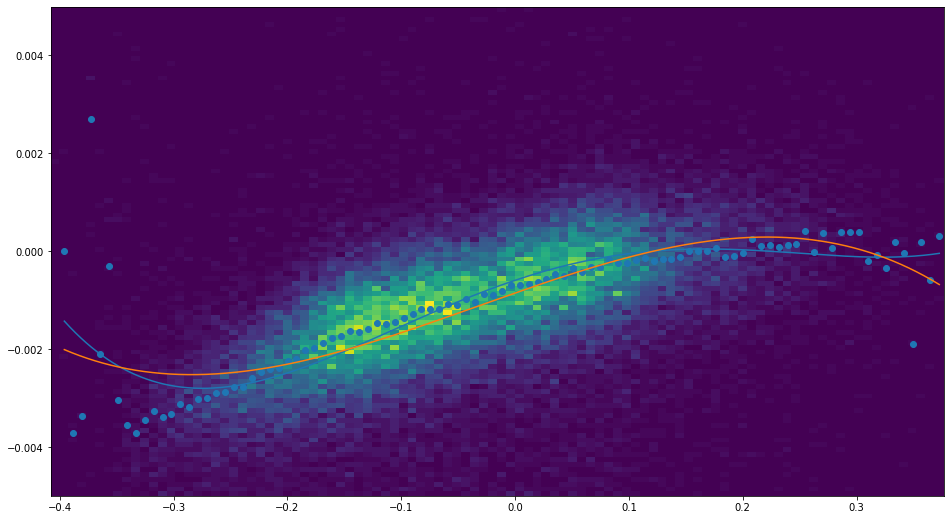

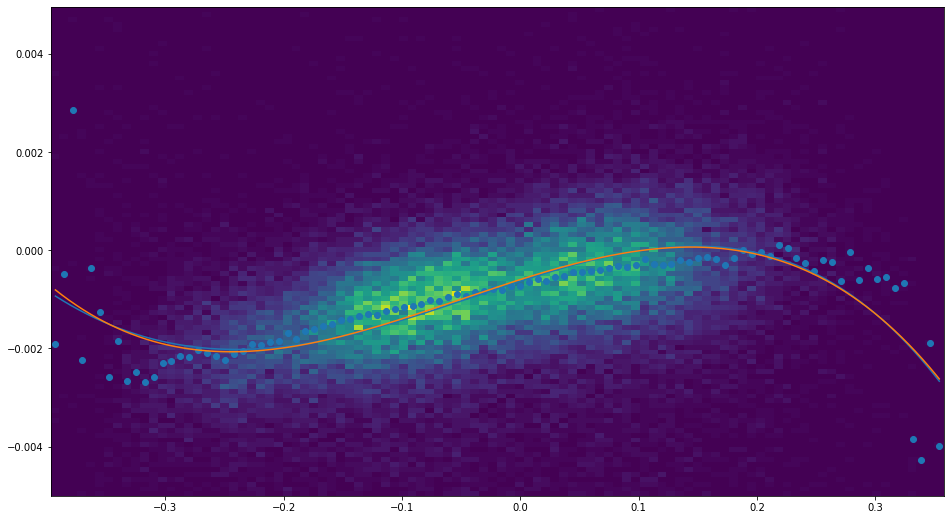

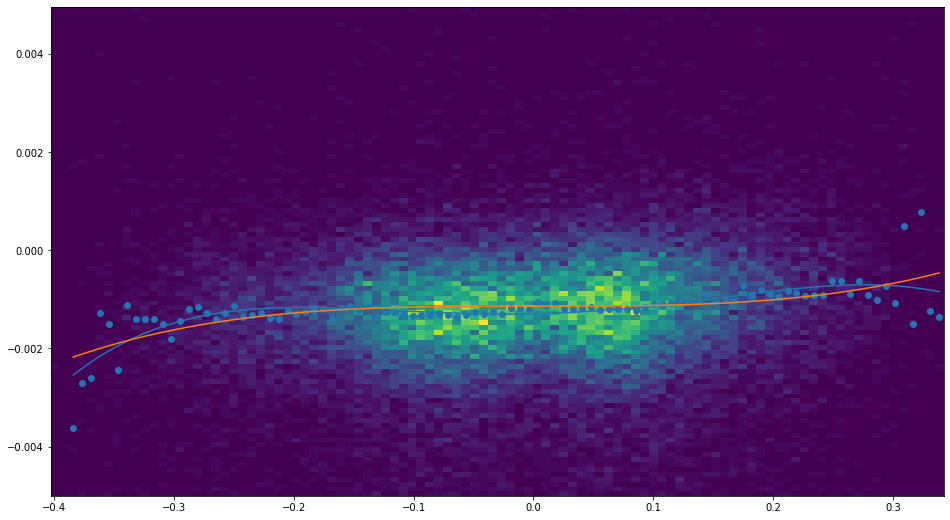

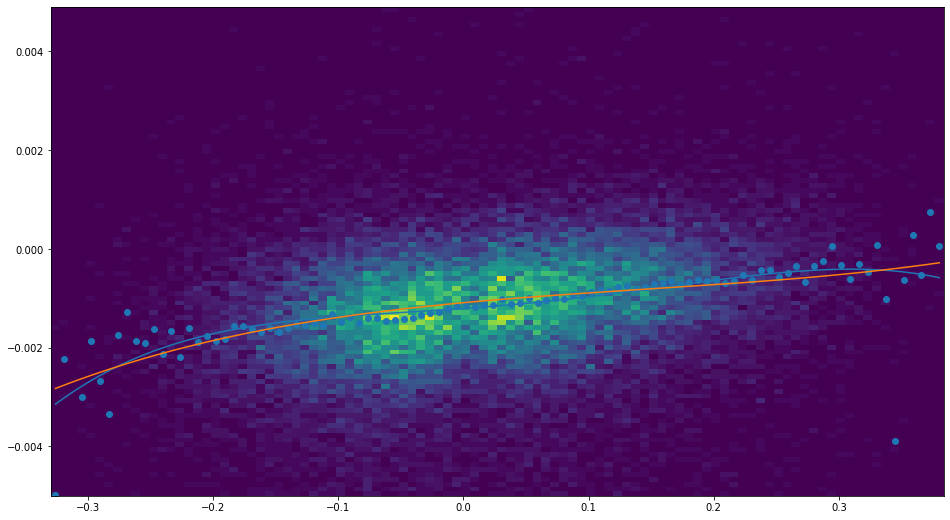

In [16]:
for sec in range(1,7):
    fig = plt.figure(figsize=(16,9))
    d = dfgrr[dfgrr.sec == sec]
    df2 = df[df.sector == sec]
    plt.hist2d(df2.e_phi_center,df2.delta_theta,bins=100)
    plt.scatter(d.phi, d.dtheta)
    
    p0=[10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    popt, pcov = curve_fit(FitFunc, d.phi, d.dtheta,p0=p0, maxfev = 3400)
    xs = np.linspace(np.min(d.phi), np.max(d.phi), 1000000)
    plt.plot(xs, FitFunc(xs, *popt))
    #print(" alpha_A= {}\n beta_A= {}\n gamma_A= {}\n alpha_B= {}\n beta_B= {}\n gamma_B= {}\n alpha_C={}\n beta_C= {}\n gamma_C= {}\n alpha_D= {}\n beta_D= {}\n gamma_D= {}\n alpha_E= {}\n beta_E= {}\n gamma_E= {}\n".format(*popt))
    
    
    popt, pcov = curve_fit(Dtheta, d.phi, d.dtheta, maxfev = 3400)
    plt.plot(xs, Dtheta(xs, *popt))
    
    
    plt.show()

In [17]:
dfgrr.head()

,phi,dtheta,sigma,sec
0,-0.342237,-0.000371,0.000000,1.0
1,-0.334903,-0.001680,0.000255,1.0
2,-0.327569,-0.002013,0.001695,1.0
3,-0.320235,-0.001525,0.001140,1.0
4,-0.312901,-0.000917,0.002450,1.0


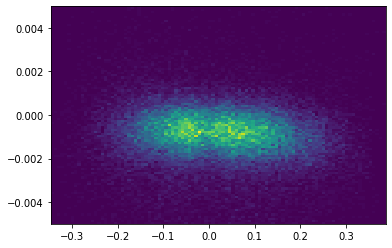

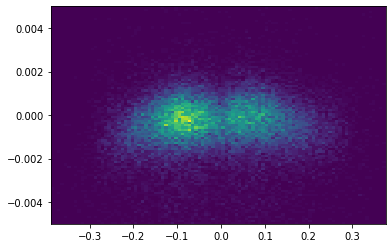

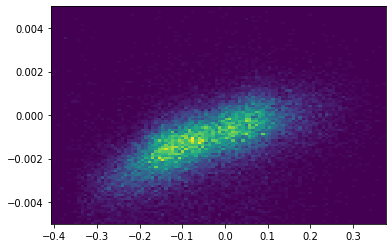

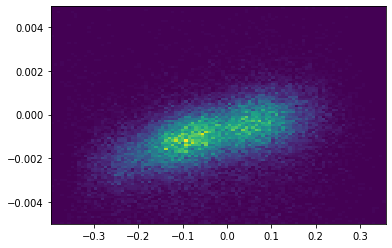

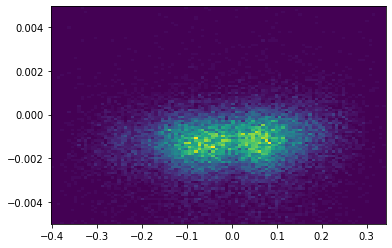

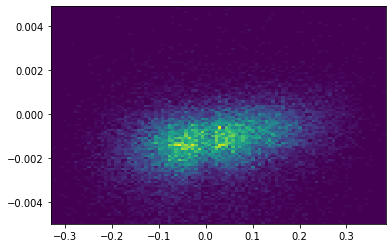

In [18]:
for sec in range(1,7):
    df2 = df[df.sector == sec]
    plt.hist2d(df2.e_phi_center,df2.delta_theta,bins=100)
    plt.show()